# Управление рисками и принятие объективного решения о покупке коров.

**Задачи проекта:**
1. Прогноз возможного удоя коровы (целевой признак Удой);
2. Рассчет вероятности получить вкусное молоко от коровы (целевой признак Вкус молока).
3. Отобрать коров по двум критериям:
- Средний удой за год — не менее 6000 килограммов;
- Молоко должно быть вкусным.


**План проекта:**
- Изучение данных;
- Предобработка данных;
- Исследовательский анализ;
- Корреляционный анализ;
- Задача регрессии;
- Задача классификации.


**Описание данных:**
1. Файл ferma_main.csv содержит данные о стаде фермера на текущий момент. Описание данных:
    - id — уникальный идентификатор коровы.
    - Удой, кг — масса молока, которую корова даёт в год (в килограммах).
    - ЭКЕ (Энергетическая кормовая единица) — показатель питательности корма коровы.
    - Сырой протеин, г — содержание сырого протеина в корме (в граммах).
    - СПО (Сахаро-протеиновое соотношение) — отношение сахара к протеину в корме коровы.
    - Порода — порода коровы.
    - Тип пастбища — ландшафт лугов, на которых паслась корова.
    - порода папы_быка — порода папы коровы.
    - Жирность,% — содержание жиров в молоке (в процентах).
    - Белок,% — содержание белков в молоке (в процентах).
    - Вкус молока — оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно).
    - Возраст — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).


2. Файл ferma_dad.csv хранит имя папы каждой коровы в стаде фермера. Описание данных:
    - id — уникальный идентификатор коровы.
    - Имя Папы — имя папы коровы.
    
    
3. Файл cow_buy.csv — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой. Описание данных:
    - Порода — порода коровы.
    - Тип пастбища — ландшафт лугов, на которых паслась корова.
    - порода папы_быка — порода папы коровы.
    - Имя_папы — имя папы коровы.
    - Текущая_жирность,% — содержание жиров в молоке (в процентах).
    - Текущий_уровень_белок,% — содержание белков в молоке (в процентах).
    - Возраст — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

In [1]:
!pip install phik -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns
import phik
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (accuracy_score,
                            confusion_matrix,
                            mean_absolute_error, mean_squared_error,
                            precision_score,
                            recall_score,
                            r2_score)

## Загрузка данных

In [3]:
try:
    ferma_main = pd.read_csv('/datasets/ferma_main.csv', sep=';', decimal = ',')
    ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';')
    cow_buy = pd.read_csv('/datasets/cow_buy.csv', sep=';', decimal = ',')
except:
    ferma_main = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_main.csv', sep=';', decimal = ',')
    ferma_dad = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_dad.csv', sep=';')
    cow_buy = pd.read_csv('https://code.s3.yandex.net/datasets/cow_buy.csv', sep=';', decimal = ',')

### 1.1 Загрузка файла данных о стаде фермера.

In [4]:
#выводим первые пять строк
ferma_main.head() 

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [5]:
#выведем информацию о датасете
ferma_main.info()
#посмотрим пропуски в данных
ferma_main.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

id                                       0
Удой, кг                                 0
ЭКЕ (Энергетическая кормовая единица)    0
Сырой протеин, г                         0
СПО (Сахаро-протеиновое соотношение)     0
Порода                                   0
Тип пастбища                             0
порода папы_быка                         0
Жирность,%                               0
Белок,%                                  0
Вкус молока                              0
Возраст                                  0
dtype: int64

In [6]:
#проверим данные на явные дубликаты
ferma_main.duplicated().sum()

5

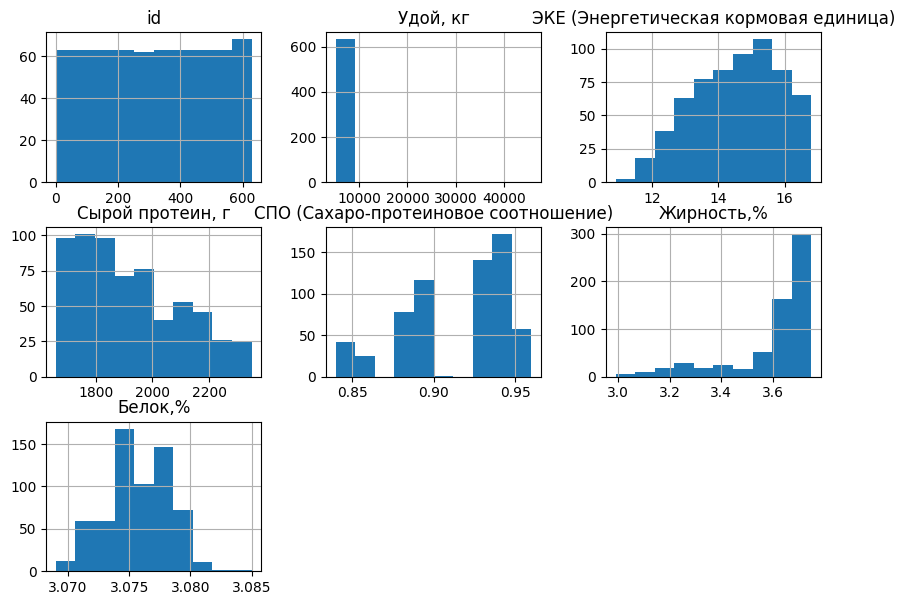

In [7]:
#посттроим диаграммы по всем числовым столцам
ferma_main.hist(figsize=(10, 7));

Вывод: По гистограммам видно, что в данных есть аномальные значения, не все данные подчиняются нормальному распределению.

### 1.2 Загрузка файла данных об имени папы каждой коровы в стаде фермера.

In [8]:
#выводим первые пять строк
ferma_dad.head()

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [9]:
#выведем информацию о датасете
ferma_dad.info()
#посмотрим пропуски в данных
ferma_dad.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


id          0
Имя Папы    0
dtype: int64

In [10]:
#проверим данные на явные дубликаты
ferma_dad.duplicated().sum()

0

### 1.3 Загрузка файла данных о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой.

In [11]:
#выводим первые пять строк
cow_buy.head()

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [12]:
#выведем информацию о датасете
cow_buy.info()
#посмотрим пропуски в данных
cow_buy.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


Порода                     0
Тип пастбища               0
порода папы_быка           0
Имя_папы                   0
Текущая_жирность,%         0
Текущий_уровень_белок,%    0
Возраст                    0
dtype: int64

In [13]:
#проверим данные на явные дубликаты
cow_buy.duplicated().sum()

4

Вывод:

- Датасет `ferma_main`: в данных имеется 634 записи, пропуски отсутствуют, имеется 5 явных дубликатов, необходимо изменить типы данных некоторых столбцов;
- Датасет `ferma_dad`: в данных имеется 629 записи, пропуски и явные дубликаты отсутствуют;
- Датасет `cow_buy`: в данных имеется 29 записей, пропуски отсутствуют, имеется 4 явных дубликата, необходимо изменить типы данных некоторых столбцов.

Во всех датасетах необходимо изменить названия столбцов к одному виду.

##  Предобработка данных

### 2.1 Переименование столбцов

In [14]:
ferma_main.rename(columns={
    'Удой, кг': 'удой, кг',
    'ЭКЕ (Энергетическая кормовая единица)': 'эке',
    'Сырой протеин, г': 'сырой_протеин, г',
    'СПО (Сахаро-протеиновое соотношение)': 'спо',
    'Порода': 'порода',
    'Тип пастбища': 'тип_пастбища',
    'порода папы_быка': 'порода_папы',
    'Жирность,%': 'жирность',
    'Белок,%': 'белок',
    'Вкус молока': 'вкус_молока',
    'Возраст': 'возраст',
}, inplace=True)

ferma_main.head(1)

,id,"удой, кг",эке,"сырой_протеин, г",спо,порода,тип_пастбища,порода_папы,жирность,белок,вкус_молока,возраст
0,1,5863,14.2,1743,0.89,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет


In [15]:
ferma_dad.rename(columns={'Имя Папы': 'имя_папы'}, inplace=True)
ferma_dad.head(1)

,id,имя_папы
0,1,Буйный


In [16]:
cow_buy.rename(columns={
    'Порода': 'порода',
    'Тип пастбища': 'тип_пастбища',
    'порода папы_быка': 'порода_папы',
    'Имя_папы': 'имя_папы',
    'Текущая_жирность,%': 'текущая_жирность',
    'Текущий_уровень_белок,%': 'текущий_белок',
    'Возраст': 'возраст',
}, inplace=True)

cow_buy.head(1)

,порода,тип_пастбища,порода_папы,имя_папы,текущая_жирность,текущий_белок,возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет


Вывод: привели названия к единому виду.

### 2.2 Обработка неявных дубликатов

In [17]:
#посмотрим униклаьные значения типа пастбища
ferma_main['тип_пастбища'] = ferma_main['тип_пастбища'].str.lower()
print(ferma_main['тип_пастбища'].unique())
print()
print(cow_buy['тип_пастбища'].unique())

['равнинное' 'равнинные' 'холмистое']

['холмистое' 'равнинное']


In [18]:
#заменим значение равнинные на равнинное
ferma_main['тип_пастбища'] = ferma_main['тип_пастбища'].replace('равнинные', 'равнинное')
ferma_main['тип_пастбища'].unique()

array(['равнинное', 'холмистое'], dtype=object)

In [19]:
#посмотрим униклаьные значения породы 
print(ferma_main['порода'].unique())
print()
print(cow_buy['порода'].unique())

['Вис Бик Айдиал' 'РефлешнСоверинг']

['Вис Бик Айдиал' 'РефлешнСоверинг']


In [20]:
#посмотрим униклаьные значения породы папы
print(ferma_main['порода_папы'].unique())
print()
print(cow_buy['порода_папы'].unique())

['Айдиал' 'Соверин' 'Айдиалл']

['Айдиал' 'Соверин']


In [21]:
ferma_main['порода'] = ferma_main['порода'].replace('Вис Бик Айдиал', 'Айдиал')
ferma_main['порода'] = ferma_main['порода'].replace('РефлешнСоверинг', 'Соверинг')
cow_buy['порода'] = cow_buy['порода'].replace('Вис Бик Айдиал', 'Айдиал')
cow_buy['порода'] = cow_buy['порода'].replace('РефлешнСоверинг', 'Соверинг')
ferma_main['порода_папы'] = ferma_main['порода_папы'].replace('Соверин', 'Соверинг')
ferma_main['порода_папы'] = ferma_main['порода_папы'].replace('Айдиалл', 'Айдиал')
cow_buy['порода_папы'] = cow_buy['порода_папы'].replace('Соверин', 'Соверинг')

In [22]:
ferma_main['вкус_молока'].unique()

array(['вкусно', 'не вкусно'], dtype=object)

In [23]:
ferma_main['возраст'].unique()

array(['более_2_лет', 'менее_2_лет'], dtype=object)

In [24]:
cow_buy['возраст'].unique()

array(['более_2_лет', 'менее_2_лет'], dtype=object)

### 2.3 Удаление явных дубликатов

In [25]:
print('Количество явных дубликатов в датасете ferma_main: ', ferma_main.duplicated().sum())
print('Количество явных дубликатов в датасете ferma_dad: ', ferma_dad.duplicated().sum())
print('Количество явных дубликатов в датасете cow_buy: ', cow_buy.duplicated().sum())

Количество явных дубликатов в датасете ferma_main:  5
Количество явных дубликатов в датасете ferma_dad:  0
Количество явных дубликатов в датасете cow_buy:  4


In [26]:
#удаляем явные дубликаты
ferma_main = ferma_main.drop_duplicates(keep='first').reset_index(drop=True)

In [27]:
print('Количество явных дубликатов в датасете ferma_main: ', ferma_main.duplicated().sum())
print('Количество явных дубликатов в датасете ferma_dad: ', ferma_dad.duplicated().sum())
print('Количество явных дубликатов в датасете cow_buy: ', cow_buy.duplicated().sum())

Количество явных дубликатов в датасете ferma_main:  0
Количество явных дубликатов в датасете ferma_dad:  0
Количество явных дубликатов в датасете cow_buy:  4


Вывод: 

- В датасете ferma_main изменили тип данных в столбцах эке, спо, жирность, %, белок, % на float;
- В датасете cow_buy изменили тип данных в столбцах текущая_жирность, %, текущий_белок, % на float;
- Удалили явные дубликаты;
- Обработали неявные дубликаты в столбцах `тип_пастбища, порода, порода_папы`.

## Исследовательский анализ данных

In [28]:
ferma_main.describe()

,id,"удой, кг",эке,"сырой_протеин, г",спо,жирность,белок
count,629.00000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,315.00000,6188.750397,14.543879,1923.364070,0.913116,3.603657,3.075671
std,181.72094,1644.795489,1.306408,182.956251,0.032203,0.168656,0.002549
min,1.00000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,158.00000,5751.000000,13.500000,1771.000000,0.890000,3.590000,3.074000
50%,315.00000,6133.000000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,472.00000,6501.000000,15.600000,2062.000000,0.940000,3.720000,3.077000
max,629.00000,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


### 3.1 Количественные признаки

In [29]:
def box_hist_plot(data, feature, title, bins):
    """
    Строит распределение и диаграмму размаха для количественных признаков
    """
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    # Строим боксплот вверху
    sns.boxplot(x=data[feature], ax=ax_box)
    # Строим гистограмму внизу
    ax_hist.hist(data[feature], bins=bins)
    plt.xlabel(title)
    plt.ylabel('Количество')
    # Убираем подпись оси X для боксплота
    ax_box.set(xlabel='')
    plt.tight_layout()
    plt.grid()
    plt.show()
    

#### 3.1.1 Удой

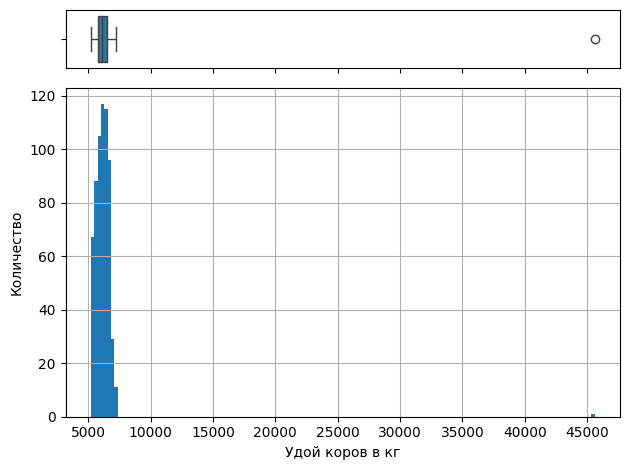

In [30]:
box_hist_plot(ferma_main, 'удой, кг', 'Удой коров в кг', 150)

Вывод: по графику видно, что значение немного больше 45000 кг является выбросром. Проверим сколько таких значений

In [31]:
ferma_main[ferma_main['удой, кг'] > 45000]

,id,"удой, кг",эке,"сырой_протеин, г",спо,порода,тип_пастбища,порода_папы,жирность,белок,вкус_молока,возраст
16,17,45616,11.5,1675,0.93,Айдиал,холмистое,Айдиал,3.22,3.076,вкусно,более_2_лет


In [32]:
#удаляем строку с выбросом
ferma_main = ferma_main.loc[ferma_main['удой, кг'] < 45000]

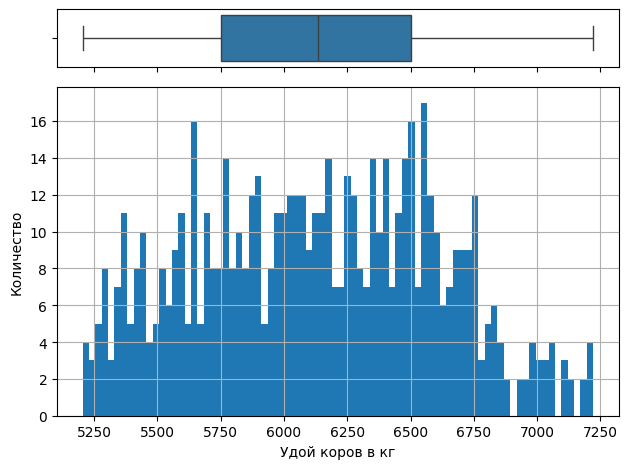

In [33]:
box_hist_plot(ferma_main, 'удой, кг', 'Удой коров в кг', 80)

Вывод: распределение похоже на нормальное, но имеет асимметрию, выбросы отсутствуют.

#### 3.1.2 ЭКЕ (Энергетическая кормовая единица)

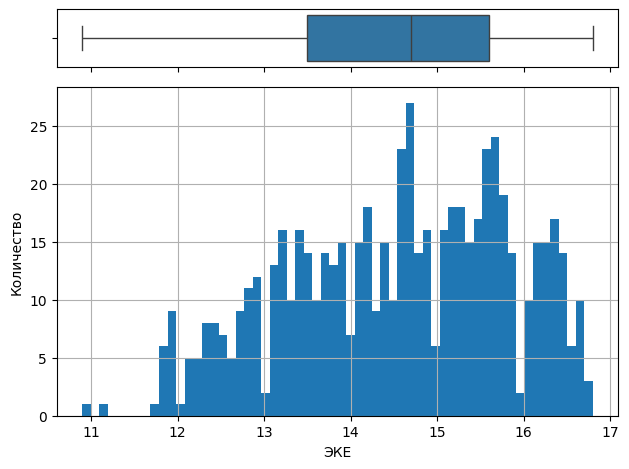

In [34]:
box_hist_plot(ferma_main, 'эке', 'ЭКЕ', 60)

Вывод: нормальное распределение, отрицательная ассиметрия, выбросы отсутствуют.

#### 3.1.3 Сырой протеин

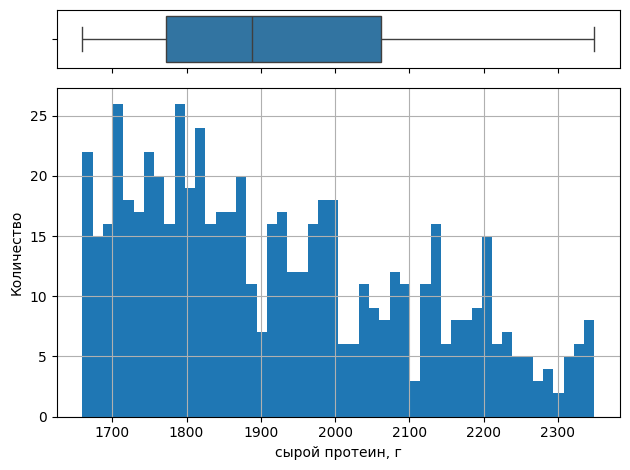

In [35]:
box_hist_plot(ferma_main, 'сырой_протеин, г', 'сырой протеин, г', 50)

Вывод: распределение нормальное, положительная асимметрия, выбросы отсутствуют.

#### 3.1.4 СПО (Сахаро-протеиновое соотношение)

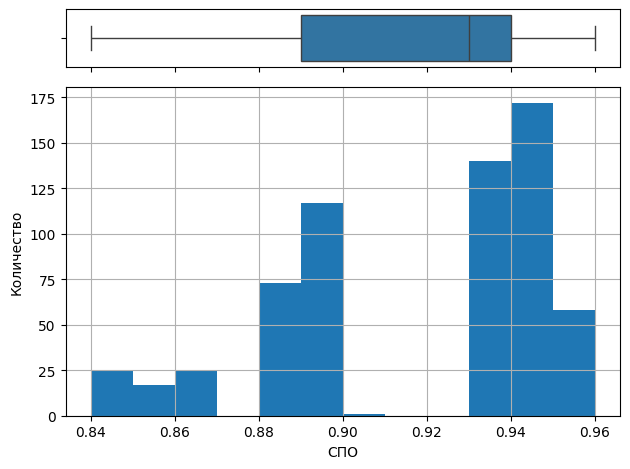

In [36]:
box_hist_plot(ferma_main, 'спо', 'СПО', 12)

Вывод: распределение не похоже на нормальное, вероятно из-за специфики признака, выбросы отсутствуют.

#### 3.1.5 Жирность

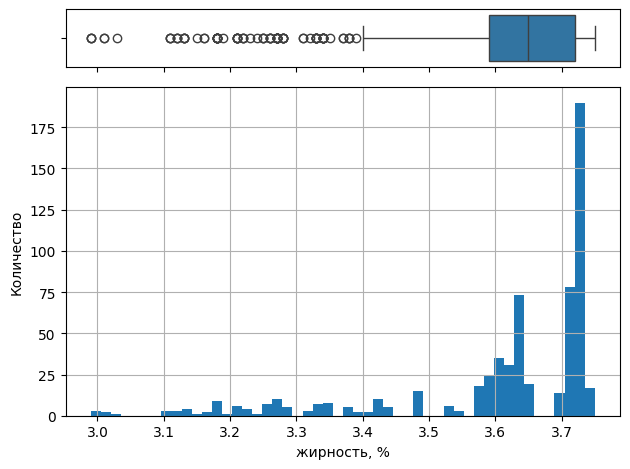

In [37]:
box_hist_plot(ferma_main, 'жирность', 'жирность, %', 50)

Вывод: распределение не похоже на нормальное, вероятно из-за специфики признака. Имеются выбросы.

In [38]:
len(ferma_main[ferma_main['жирность'] < 3.4]) / len(ferma_main) * 100

13.694267515923567

Вывод: доля выбросов по признаку жирность составляет 13.7%, оставим данные выбросы, так как удаление может негативно повлиять на качество данных.

#### 3.1.6 Белок

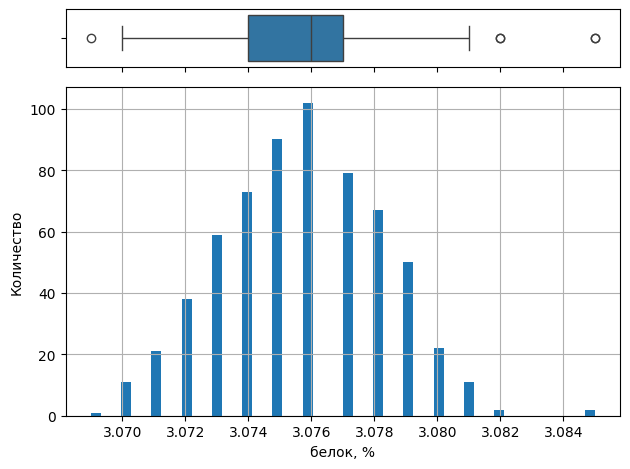

In [39]:
box_hist_plot(ferma_main, 'белок', 'белок, %', 50)

Вывод: нормальное распределение, имеются выбросы.

In [40]:
ferma_main = ferma_main.query('3.07 < белок < 3.081')

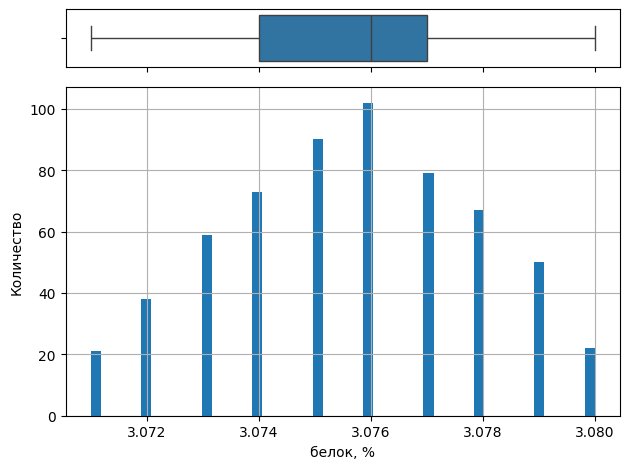

In [41]:
box_hist_plot(ferma_main, 'белок', 'белок, %', 50)

### 3.2 Категориальные признаки

In [42]:
def pie_plotter(data, feature, title):
    """
    Строит круговую диаграмму распределения для категориальных данных
    """
    fig = plt.figure(figsize=(6, 4))
    values = data[feature].value_counts()
    plt.pie(
    values,
    labels = values.index,
    autopct='%1.1f%%',
    )
    plt.title(title)
    
    plt.show()

#### 3.2.1 Порода

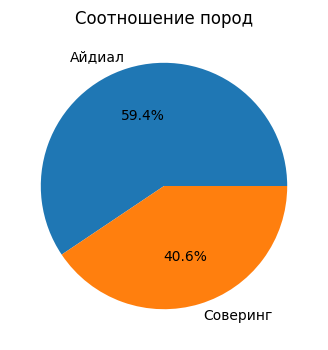

In [43]:
pie_plotter(ferma_main, 'порода', 'Соотношение пород')

Вывод: 59.2% породы Вис Бик Айдиал, 40.8% - Рефлешн Соверинг.

#### 3.2.2 Тип пастбища

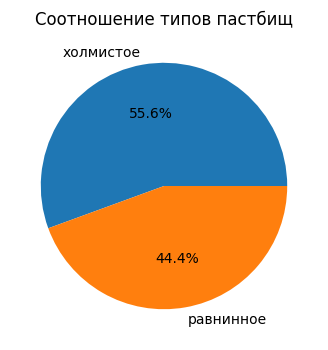

In [44]:
pie_plotter(ferma_main, 'тип_пастбища', 'Соотношение типов пастбищ')

Вывод: 55.7% - холмистое, 44.3% - равнинное.

#### 3.2.3 Порода папы

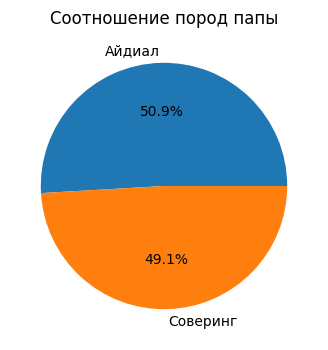

In [45]:
pie_plotter(ferma_main, 'порода_папы', 'Соотношение пород папы')

Вывод: 50.9% породы папы Вис Бик Айдиал, 49.1% - Рефлешн Соверинг.

#### 3.2.4 Вкус молока

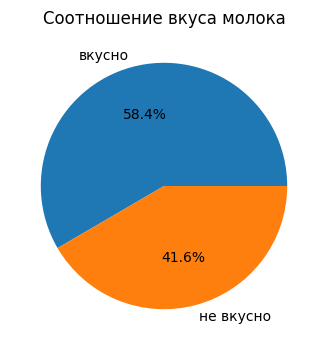

In [46]:
pie_plotter(ferma_main, 'вкус_молока', 'Соотношение вкуса молока')

Вывод: 58.9% молока вкусное, 41.1% - не вкусное.

#### 3.2.5 Возраст

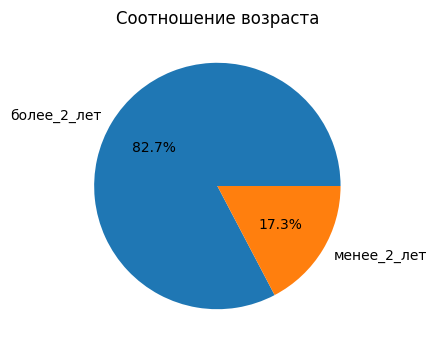

In [47]:
pie_plotter(ferma_main, 'возраст', 'Соотношение возраста')

Вывод: большая часть - 82.5% возрастом более двух лет, меньшая часть - 17.5% возрастом менее двух лет.

## Корреляционный анализ

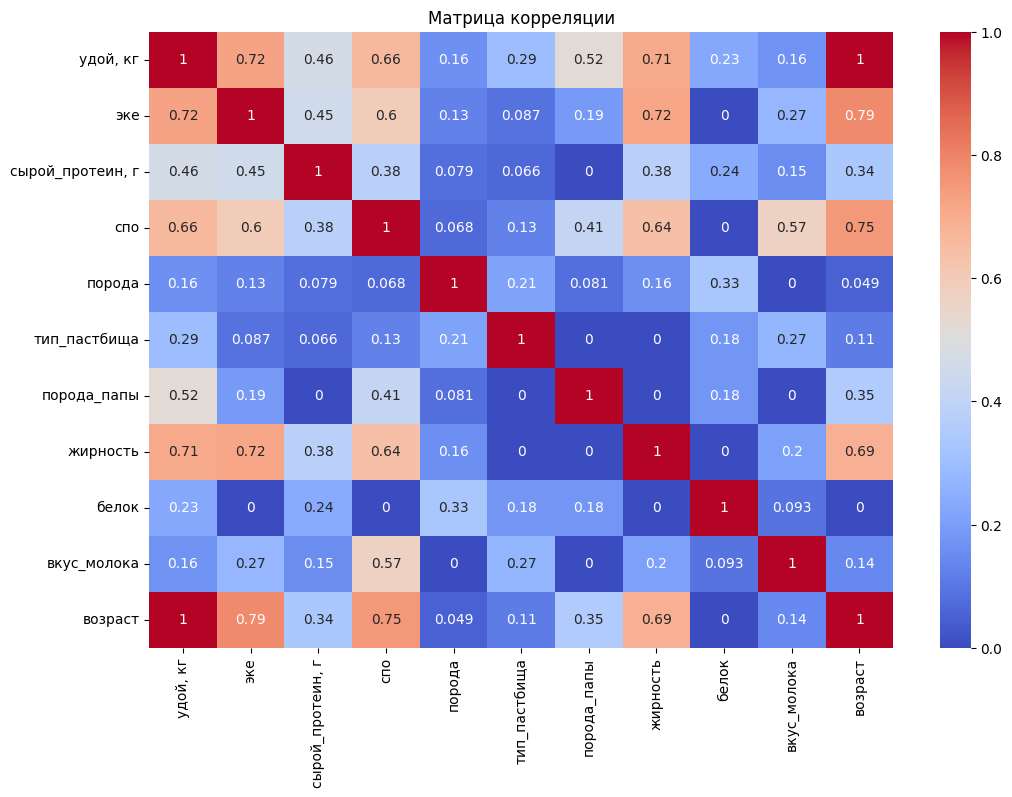

In [48]:
plt.figure(figsize=(12, 8))
sns.heatmap(ferma_main.drop('id', axis=1).phik_matrix(interval_cols=['удой, кг', 'эке', 'сырой_протеин, г', 'спо', 'жирность', 'белок']), annot=True, cmap="coolwarm")
plt.title('Матрица корреляции')
plt.show()

In [49]:
def scatter_plotter(feature, title):
    """
    Строит диаграмму рассеяния
    """
    fig, ax = plt.subplots(figsize = (7, 5))
    sns.set_style('whitegrid')
    sns.scatterplot(
        data=ferma_main, 
        x=feature, 
        y='удой, кг', 
        hue='порода',
        palette='seismic'
    )
    ax.set_title(title)

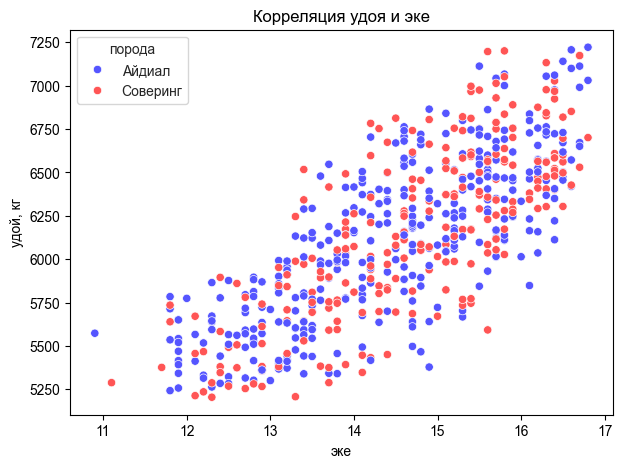

In [50]:
scatter_plotter('эке', 'Корреляция удоя и эке')

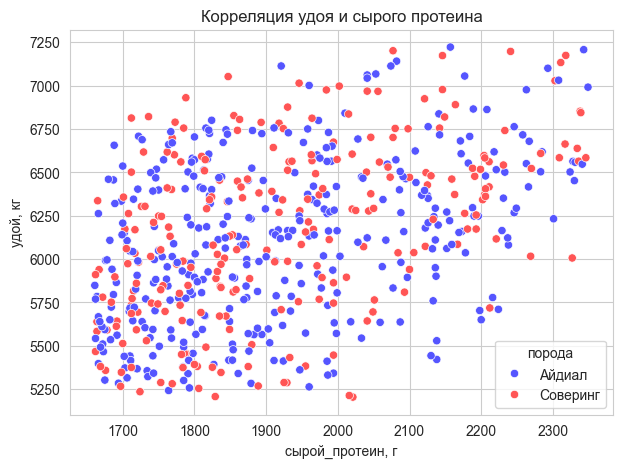

In [51]:
scatter_plotter('сырой_протеин, г', 'Корреляция удоя и сырого протеина')

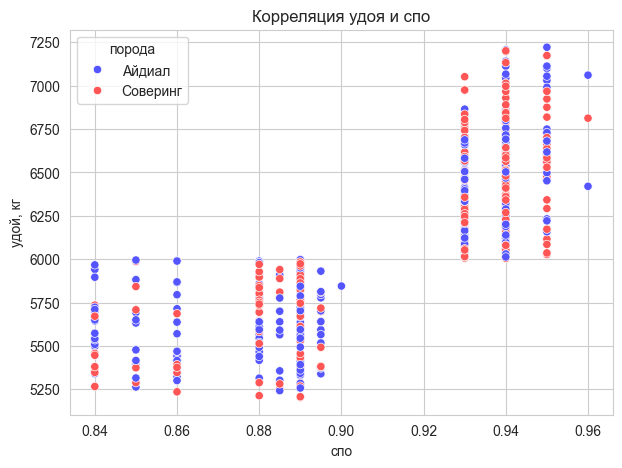

In [52]:
scatter_plotter('спо', 'Корреляция удоя и спо')

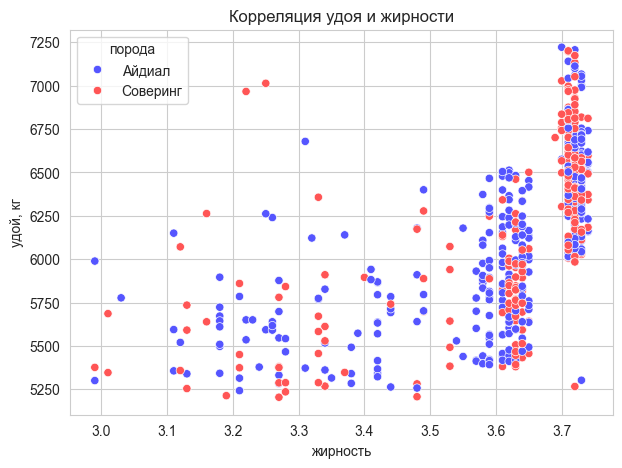

In [53]:
scatter_plotter('жирность', 'Корреляция удоя и жирности')

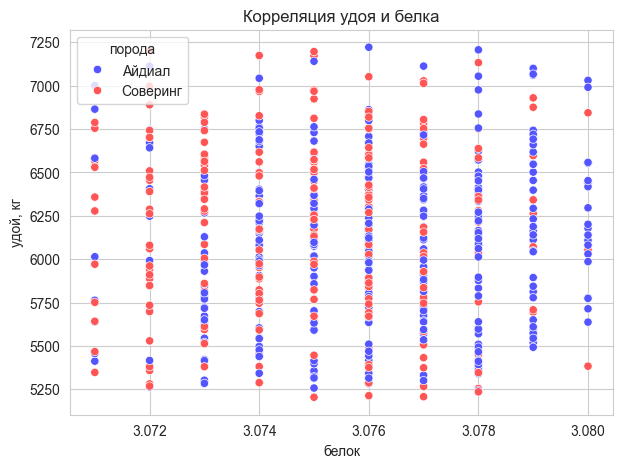

In [54]:
scatter_plotter('белок', 'Корреляция удоя и белка')

Вывод:
1. Принимаем столбец `удой, кг` как целевой признак.
    - ЭКЕ: коэффициент корреляции равен 0.72 это указывает на достаточно сильную положительную взаимосвязь, по диаграмме рассеяния видно, что для обоих пород это утверждение справедливо, с увеличением удоя увеличивается ЭКЕ.
    - Сырой протеин: коэффициент корреляции равен 0.46, по диаграмме рассеяния виден большой разброс значений, при этом наблюдается положительная зависимость.
    - СПО: коэффициент корреляции равен 0.66, по диаграмме рассеяния видна тенденция к кластеризации, нелинейная зависимость.
    - Жирность: коэффициент корреляции равен 0.71, наблюдается тенденция к кластеризации, до значения жирности 3,5 наблюдается разброс значений.
    - Белок: коэффициент корреляции равен 0.23 указывает на нелинейную взаимосвязь признаков, по диаграмме рассеяния видно, что есть зависимость белка и породой. Больше белка у породы Вис Бик Айдиал, меньше у Рефлешн Соверинг.


2. Нелинейные связи имеются, потребуется добавление новых признаков.


3. Матрица корреляции показала, что между некоторыми входными признаками есть умеренная корреляция, но нет явных признаков сильной мультиколлинеарности.

## Обучение модели линейной регрессии

### 5.1 Модель 1

Исходя из матрицы корреляций и построенных диаграмм рассеяния удалим признаки `id, белок, жирность`. Связь признака `белок` и целевого признака отсутствует, признак `жирность` не связан напрямую с целевым признаком, `id` для обучения модели не нужен.

In [55]:
ferma_main_lin = ferma_main.drop(['id', 'белок', 'жирность'], axis=1)
ferma_main_lin.head(1)

,"удой, кг",эке,"сырой_протеин, г",спо,порода,тип_пастбища,порода_папы,вкус_молока,возраст
0,5863,14.2,1743,0.89,Айдиал,равнинное,Айдиал,вкусно,более_2_лет


In [56]:
X = ferma_main_lin.drop('удой, кг', axis=1)
y = ferma_main_lin['удой, кг']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print('Train:', X_train.shape, y_train.shape )
print('Test:', X_test.shape, y_test.shape)

Train: (450, 8) (450,)
Test: (151, 8) (151,)


In [61]:
#разделим признаки на категориальные и количественные
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы', 'вкус_молока', 'возраст']
num_col_names = ['эке', 'сырой_протеин, г', 'спо']

#кодируем категориальные признаки
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names_out()

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

#масштабируем количественные признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [62]:
model = LinearRegression()
model_1 = model.fit(X_train, y_train)
predictions_1 = model_1.predict(X_test)
r2_1 = r2_score(y_test, predictions_1)
print(f'R2_score первой модели: {r2_1}')

R2_score первой модели: 0.7972160506784115


In [63]:
mse_1 = mean_squared_error(y_test, predictions_1)
mae_1 = mean_absolute_error(y_test, predictions_1)
rmse_1 = np.sqrt(mean_squared_error(y_test, predictions_1))

print('Train MSE: {:.1f}'.format(mse_1))
print('Train MAE: {:.1f}'.format(mae_1))
print('Train RMSE: {:.1f}'.format(rmse_1))

Train MSE: 49195.1
Train MAE: 175.6
Train RMSE: 221.8


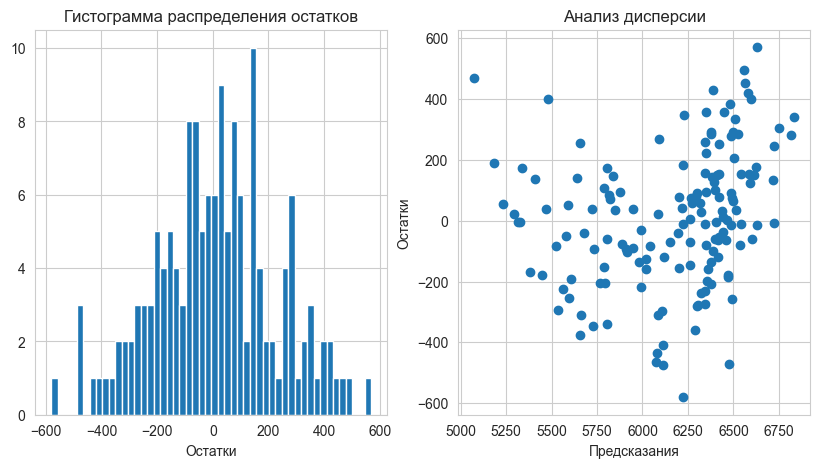

In [64]:
residuals_1 = y_test - predictions_1
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals_1, bins=50)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=predictions_1, y=residuals_1)
axes[1].set_title('Анализ дисперсии')
axes[1].set_xlabel('Предсказания')
axes[1].set_ylabel('Остатки')
plt.show()

Вывод: коэффициент детерминации R2 = 0.797 говорит о том, что модель объясняет 79,7% вариации данных.
Остатки имеют нормальное распределение с отрицательной асимметрией. Это означает, что модель завышает прогнозные значения.
При анализе дисперсии ошибок при различных прогнозах можно отметить, что модель чаще или сильно ошибается, предсказывая удой сильно выше или сильно ниже среднего, модель непостоянная. Данную ситуацию можно исправить либо, добавив больше признаков, либо, изменив взаимосвязь входных признаков с целевым.

### 5.2 Модель 2

Из ранее представленных графиков можно заметить, что признаки СПО и ЭКЕ связаны нелинейно с признаком удой. Переведем СПО в категориальный признак. Из диаграммы рассеяния видно, что граница проходит в интервале от 0.90 до 0.93. Выберем за границу 0.92 и поделим СПО на 2 категории: "менее_0.92" и "более_0.92". Для исправления нелинейности между признаком ЭКЕ и признаком удой возведем признак в квадрат.

In [65]:
ferma_main['спо_кат'] = ferma_main['спо'].apply(lambda x: 'менее_0.92' if x < 0.92 else 'более_0.92')
ferma_main['эке_2'] = ferma_main['эке'].apply(lambda x: x**2)

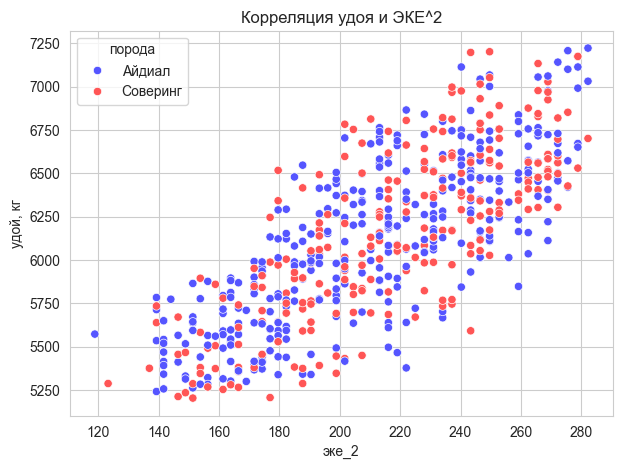

In [66]:
scatter_plotter('эке_2', 'Корреляция удоя и ЭКЕ^2')

In [67]:
ferma_main_lin_2 = ferma_main.drop(['id', 'белок', 'жирность', 'эке', 'спо'], axis=1)
ferma_main_lin_2.head(1)

,"удой, кг","сырой_протеин, г",порода,тип_пастбища,порода_папы,вкус_молока,возраст,спо_кат,эке_2
0,5863,1743,Айдиал,равнинное,Айдиал,вкусно,более_2_лет,менее_0.92,201.64


In [68]:
X = ferma_main_lin_2.drop('удой, кг', axis=1)
y = ferma_main_lin_2['удой, кг']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print('Train:', X_train.shape, y_train.shape )
print('Test:', X_test.shape, y_test.shape)

Train: (450, 8) (450,)
Test: (151, 8) (151,)


In [70]:
#разделим признаки на категориальные и количественные
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы', 'вкус_молока', 'возраст', 'спо_кат']
num_col_names = ['эке_2', 'сырой_протеин, г']

#кодируем категориальные признаки
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names_out()

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

#масштабируем количественные признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [71]:
model_2 = model.fit(X_train, y_train)
predictions_2 = model_2.predict(X_test)
r2_2 = r2_score(y_test, predictions_2)
print(f'R2_score второй модели: {r2_2}')

R2_score второй модели: 0.8242474978335578


In [72]:
mse_2 = mean_squared_error(y_test, predictions_2)
mae_2 = mean_absolute_error(y_test, predictions_2)
rmse_2 = np.sqrt(mean_squared_error(y_test, predictions_2))

print('Train MSE: {:.1f}'.format(mse_2))
print('Train MAE: {:.1f}'.format(mae_2))
print('Train RMSE: {:.1f}'.format(rmse_2))

Train MSE: 42637.3
Train MAE: 160.7
Train RMSE: 206.5


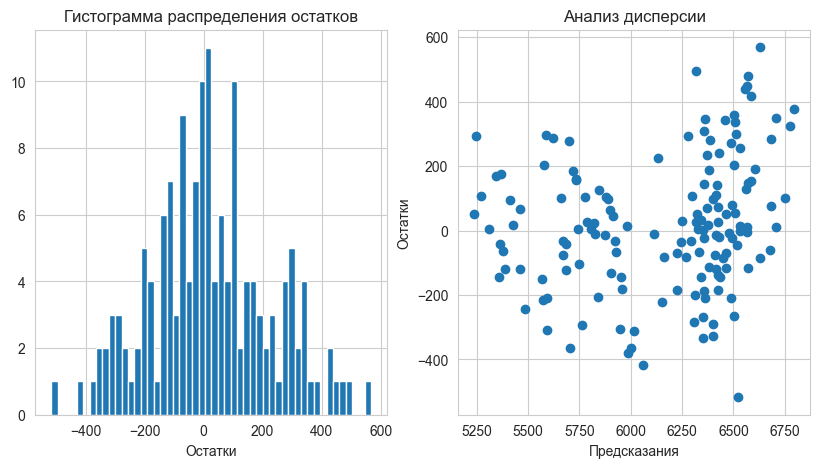

In [73]:
residuals_2 = y_test - predictions_2
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals_2, bins=50)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=predictions_2, y=residuals_2)
axes[1].set_title('Анализ дисперсии')
axes[1].set_xlabel('Предсказания')
axes[1].set_ylabel('Остатки')
plt.show()

Вывод: коэффициент детерминации R2 = 0.824 говорит о том, что модель объясняет 82,4% вариации данныхв. Это почти на 3% больше, чем у первой модель.
Большинство остатков сосредоточено около нуля, что указывает на то, что модель в целом хорошо предсказывает значения. Однако есть несколько выбросов с большими остатками, что может свидетельствовать о наличии аномалий или ошибок в данных.
Модель в целом хорошо предсказывает значения, так как большинство остатков сосредоточено около нуля, и точки на диаграмме рассеяния более равномерно распределены вокруг горизонтальной линии, чем у первой модели. Однако наличие выбросов и точек, значительно отклоняющихся от линии, указывает на то, что модель может быть улучшена.

### 5.3 Модель 3

In [74]:
ferma = ferma_main.merge(ferma_dad, on='id', how='left')
ferma.head()

,id,"удой, кг",эке,"сырой_протеин, г",спо,порода,тип_пастбища,порода_папы,жирность,белок,вкус_молока,возраст,спо_кат,эке_2,имя_папы
0,1,5863,14.2,1743,0.890,Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,менее_0.92,201.64,Буйный
1,2,5529,12.8,2138,0.890,Айдиал,равнинное,Соверинг,3.54,3.079,вкусно,менее_2_лет,менее_0.92,163.84,Соловчик
2,3,5810,14.0,1854,0.885,Соверинг,холмистое,Соверинг,3.59,3.074,не вкусно,более_2_лет,менее_0.92,196.00,Барин
3,4,5895,12.4,2012,0.885,Соверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,менее_0.92,153.76,Буйный
4,5,5302,12.8,1675,0.885,Айдиал,равнинное,Соверинг,3.73,3.073,вкусно,менее_2_лет,менее_0.92,163.84,Барин


In [75]:
ferma_lin = ferma.drop(['id', 'белок', 'жирность', 'вкус_молока', 'эке', 'спо'], axis=1)
ferma_lin.head(1)

,"удой, кг","сырой_протеин, г",порода,тип_пастбища,порода_папы,возраст,спо_кат,эке_2,имя_папы
0,5863,1743,Айдиал,равнинное,Айдиал,более_2_лет,менее_0.92,201.64,Буйный


In [76]:
X = ferma_lin.drop('удой, кг', axis=1)
y = ferma_lin['удой, кг']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print('Train:', X_train.shape, y_train.shape )
print('Test:', X_test.shape, y_test.shape)

Train: (450, 8) (450,)
Test: (151, 8) (151,)


In [77]:
#разделим признаки на категориальные и количественные
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы', 'возраст', 'спо_кат', 'имя_папы']
num_col_names = ['эке_2', 'сырой_протеин, г']

#кодируем категориальные признаки
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names_out()

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

#масштабируем количественные признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [78]:
model_3 = model.fit(X_train, y_train)
predictions_3 = model_3.predict(X_test)
r2_3 = r2_score(y_test, predictions_3)
print(f'R2_score третьей модели: {r2_3}')

R2_score третьей модели: 0.8439009446099739


In [79]:
mse_3 = mean_squared_error(y_test, predictions_3)
mae_3 = mean_absolute_error(y_test, predictions_3)
rmse_3 = np.sqrt(mean_squared_error(y_test, predictions_3))

print('Train MSE: {:.1f}'.format(mse_1))
print('Train MAE: {:.1f}'.format(mae_1))
print('Train RMSE: {:.1f}'.format(rmse_1))

Train MSE: 49195.1
Train MAE: 175.6
Train RMSE: 221.8


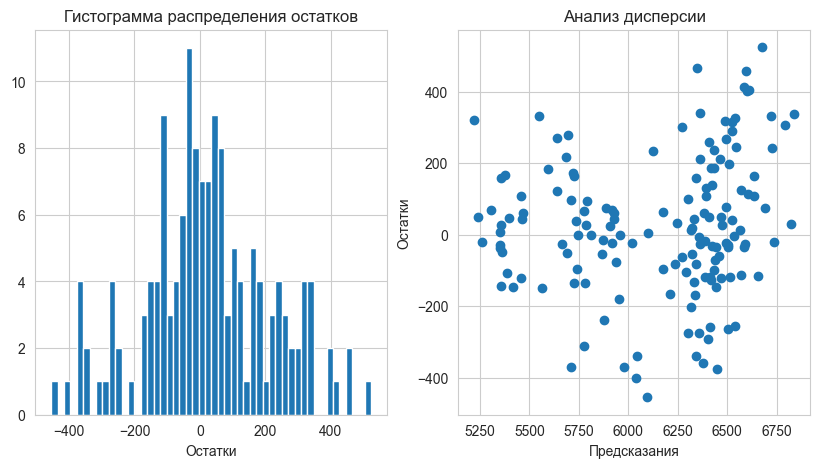

In [80]:
residuals_3 = y_test - predictions_3
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals_3, bins=50)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=predictions_3, y=residuals_3)
axes[1].set_title('Анализ дисперсии')
axes[1].set_xlabel('Предсказания')
axes[1].set_ylabel('Остатки')
plt.show()

Вывод: коэффициент детерминации R2 = 0.845 говорит о том, что модель хорошо себя показывает в 84% случаев. Это наибольшее значение из рассматриваемых моделей.
Остатки имеют симметричное нормальное распределение. Добавление нового признака убрало асимметрию распределения ошибок. Это означает, что модель стала точнее.
При анализе дисперсии ошибок при различных прогнозах можно заметить, что она более стабильна по сравнению с первой моделью, и немного стабильнее второй.
Опираясь на приведенный результат, можно сказать, что третья модель оказалась более точной. Таким образом, уменьшение нелинейности между входными признаками и целевым, а также добавление в расчет еще одного входного признака повлияло на модель в лучшую сторону.

### 5.4 Сравнение трех моделей

In [81]:
print(f'R2_score первой модели: {r2_1}')
print(f'R2_score второй модели: {r2_2}')
print(f'R2_score третьей модели: {r2_3}')

R2_score первой модели: 0.7972160506784115
R2_score второй модели: 0.8242474978335578
R2_score третьей модели: 0.8439009446099739


Остатки:
- Первая модель: остатки имеют асимметричное нормальное распределение со смещением влево. Это означает, что модель завышает прогнозные значения. При анализе дисперсии ошибок при различных прогнозах можно отметить, что модель чаще или сильнее ошибается, предсказывая удой сильно выше или сильно ниже среднего. То есть она непостоянная. Это говорит о неточности модели.
- Вторая модель: остатки имеют асимметричное нормальное распределение со смещением влево. Это означает, что модель завышает прогнозные значения. При этом это смещение оказалось меньше, чем у предыдущей модели. При анализе дисперсии ошибок при различных прогнозах можно заметить, что она стала более стабильной по сравнению с предыдущей моделью.
- Третья модель: остатки имеют симметричное нормальное распределение. Добавление нового признака убрало асимметрию распределения ошибок. Это означает, что модель стала точнее. При анализе дисперсии ошибок при различных прогнозах можно заметить, что она более стабильна по сравнению с первой моделью. И немного стабильнее второй.

### 5.5 Оценка качества моделей

In [82]:
df = pd.DataFrame({
    'Модель': ['Первая', 'Вторая', 'Третья'],
    'MSE': [mse_1, mse_2, mse_3],
    'MAE': [mae_1, mae_2, mae_3],
    'RMSE': [rmse_1, rmse_2, rmse_3]
})

df

,Модель,MSE,MAE,RMSE
0,Первая,49195.095354,175.584788,221.799674
1,Вторая,42637.305032,160.736309,206.488026
2,Третья,37869.407023,149.600595,194.600635


Вывод: третья модель имеет меньшие показатели ошибок, следовательно она является самой точной.

In [85]:
st.norm.interval(alpha=0.05, loc=np.mean(predictions_3), scale=st.sem(predictions_3))

(6142.922371205046, 6147.300214228888)

Вывод: 95% доверительный интервал третьей модели (6142.922371205046, 6147.300214228888)

### 5.6 Предсказание удоя коров

In [86]:
#создаем копию датасета
cow_buy_copy = cow_buy.copy(deep=True)

#считаем среднее значение каждого недостающего признака и увеличиваем их на 5%
mean_values = ferma_main[['эке', 'сырой_протеин, г', 'спо']].mean()
new_values = mean_values * 1.05


#добавляем недостающие признаки в датасет cow_buy и преобразовываем их
cow_buy_copy['эке'] = new_values['эке']
cow_buy_copy['эке_2'] = cow_buy_copy['эке'] ** 2
cow_buy_copy['сырой_протеин, г'] = new_values['сырой_протеин, г']
cow_buy_copy['спо'] = new_values['спо']
cow_buy_copy['спо_кат'] = cow_buy_copy['спо'].apply(lambda x: 'менее_0.92' if x < 0.92 else 'более_0.92')

#удаляем ненужные столбцы cow_buy
cow_buy_copy = cow_buy_copy.drop(['текущий_белок', 'текущая_жирность', 'эке', 'спо'], axis=1)
cow_buy_copy.head()

,порода,тип_пастбища,порода_папы,имя_папы,возраст,эке_2,"сырой_протеин, г",спо_кат
0,Айдиал,холмистое,Айдиал,Геркулес,более_2_лет,233.063152,2019.55183,более_0.92
1,Айдиал,равнинное,Соверинг,Буйный,менее_2_лет,233.063152,2019.55183,более_0.92
2,Соверинг,равнинное,Соверинг,Барин,более_2_лет,233.063152,2019.55183,более_0.92
3,Соверинг,холмистое,Айдиал,Буйный,более_2_лет,233.063152,2019.55183,более_0.92
4,Соверинг,равнинное,Айдиал,Буйный,более_2_лет,233.063152,2019.55183,более_0.92


In [87]:
cow_buy_copy['спо_кат'].unique()

array(['более_0.92'], dtype=object)

In [89]:
#разделим признаки на категориальные и количественные
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы', 'возраст', 'спо_кат', 'имя_папы']
num_col_names = ['эке_2', 'сырой_протеин, г']

#кодируем категориальные признаки
#encoder = OneHotEncoder(drop='first', sparse=False)
cow_buy_ohe = encoder.transform(cow_buy_copy[cat_col_names])
encoder_col_names = encoder.get_feature_names_out()

cow_buy_ohe = pd.DataFrame(cow_buy_ohe, columns=encoder_col_names)


#масштабируем количественные признаки
#scaler = StandardScaler()
cow_buy_scaled = scaler.transform(cow_buy_copy[num_col_names])
cow_buy_scaled = pd.DataFrame(cow_buy_scaled, columns=num_col_names)


cow_buy_new = pd.concat([cow_buy_ohe, cow_buy_scaled], axis=1)

In [90]:
cow_buy['удой, кг'] = model_3.predict(cow_buy_new)
cow_buy.sort_values(by='удой, кг')

,порода,тип_пастбища,порода_папы,имя_папы,текущая_жирность,текущий_белок,возраст,"удой, кг"
13,Айдиал,холмистое,Соверинг,Барин,3.42,3.075,менее_2_лет,6093.969333
2,Соверинг,равнинное,Соверинг,Барин,3.59,3.074,более_2_лет,6282.933373
14,Соверинг,равнинное,Соверинг,Барин,3.59,3.074,более_2_лет,6282.933373
8,Соверинг,равнинное,Соверинг,Барин,3.59,3.074,более_2_лет,6282.933373
1,Айдиал,равнинное,Соверинг,Буйный,3.54,3.081,менее_2_лет,6308.506499
16,Айдиал,холмистое,Соверинг,Соловчик,3.73,3.079,более_2_лет,6347.398921
10,Айдиал,холмистое,Соверинг,Соловчик,3.73,3.055,более_2_лет,6347.398921
9,Соверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,6356.879811
17,Соверинг,равнинное,Соверинг,Геркулес,3.77,3.053,менее_2_лет,6376.723578
5,Соверинг,равнинное,Соверинг,Геркулес,3.63,3.053,менее_2_лет,6376.723578


Вывод: 
- Обучили три разных модели.
- Выявили лучшую модель с метриками: 
    - R2 = 0.843
    - MSE = 37869.407023
    - MAE = 149.600595
    - RMSE = 194.600635
- Рассчитали 95% доверительный интервал третьей модели (6076.696292148339, 6213.551978974312)
- Спрогнозировали годовой удой коров, который варьируется от 6093 до 6593 кг.

## Обучение модели логистической регрессии

In [91]:
ferma.head()

,id,"удой, кг",эке,"сырой_протеин, г",спо,порода,тип_пастбища,порода_папы,жирность,белок,вкус_молока,возраст,спо_кат,эке_2,имя_папы
0,1,5863,14.2,1743,0.890,Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,менее_0.92,201.64,Буйный
1,2,5529,12.8,2138,0.890,Айдиал,равнинное,Соверинг,3.54,3.079,вкусно,менее_2_лет,менее_0.92,163.84,Соловчик
2,3,5810,14.0,1854,0.885,Соверинг,холмистое,Соверинг,3.59,3.074,не вкусно,более_2_лет,менее_0.92,196.00,Барин
3,4,5895,12.4,2012,0.885,Соверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,менее_0.92,153.76,Буйный
4,5,5302,12.8,1675,0.885,Айдиал,равнинное,Соверинг,3.73,3.073,вкусно,менее_2_лет,менее_0.92,163.84,Барин


In [92]:
ferma_log = ferma.copy(deep=True)
ferma_log['вкус_молока_кат'] = ferma_log['вкус_молока'].apply(lambda x: 1 if x == 'вкусно' else 0)
ferma_log = ferma_log.drop(['эке', 'спо', 'вкус_молока'], axis=1)
ferma_log.head()

,id,"удой, кг","сырой_протеин, г",порода,тип_пастбища,порода_папы,жирность,белок,возраст,спо_кат,эке_2,имя_папы,вкус_молока_кат
0,1,5863,1743,Айдиал,равнинное,Айдиал,3.58,3.076,более_2_лет,менее_0.92,201.64,Буйный,1
1,2,5529,2138,Айдиал,равнинное,Соверинг,3.54,3.079,менее_2_лет,менее_0.92,163.84,Соловчик,1
2,3,5810,1854,Соверинг,холмистое,Соверинг,3.59,3.074,более_2_лет,менее_0.92,196.00,Барин,0
3,4,5895,2012,Соверинг,холмистое,Айдиал,3.40,3.075,более_2_лет,менее_0.92,153.76,Буйный,0
4,5,5302,1675,Айдиал,равнинное,Соверинг,3.73,3.073,менее_2_лет,менее_0.92,163.84,Барин,1


In [93]:
X = ferma_log.drop('вкус_молока_кат', axis=1)
y = ferma_log['вкус_молока_кат']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


print('Train:', X_train.shape, y_train.shape )
print('Test:', X_test.shape, y_test.shape)

Train: (450, 12) (450,)
Test: (151, 12) (151,)


In [94]:
#разделим признаки на категориальные и количественные
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы', 'возраст', 'спо_кат', 'имя_папы']
num_col_names = ['эке_2', 'сырой_протеин, г', 'жирность', 'белок', 'удой, кг']

#кодируем категориальные признаки
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names_out()

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

#масштабируем количественные признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [95]:
clf = LogisticRegression()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [96]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))

Accuracy: 0.596
Precision: 0.629
Recall: 0.750


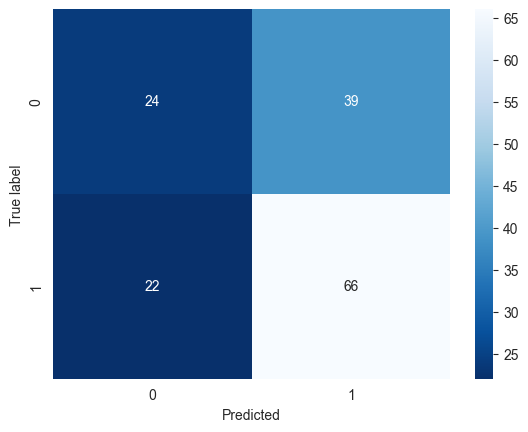

In [97]:
# Построение матрицы ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted');

Вывод: точность модели 58.9%. Ошибки первого рода критичнее всего.
- Precision: в метрике задействуются ответы TP и FP. Количество FP (ошибок первого рода) нужно сводить к минимуму, так как они показывают ложно положительные ответы. В таком случае нужно максимизировать метрику Precision. 
- Recall: в метрике задействуются ответы TP и FN. Ошибки второго рода - не критичны для нас, поскольку нет страшного в том, что мы не предложим фермеру несколько коров, у которых вкусное молоко. Гораздо хуже будет, если предложить не вкусное.

### Анализ модели логистической регресии

In [98]:
y_proba = clf.predict_proba(X_test)[:, 1]

data = pd.DataFrame(zip(y_test, y_proba),
                          columns=['y_test', 'y_proba']).sort_values(by='y_proba', ascending=False)

data.head()

,y_test,y_proba
87,1,0.892437
2,1,0.875054
118,1,0.865457
19,1,0.853322
120,1,0.852824


In [99]:
data_1 = data.copy(deep=True)

thresholds_1 = [round(i,2) for i in np.linspace(0.1,1,num = 10,endpoint=False)]

columns = []

for i in thresholds_1:
    columns.append('y_pred_'+str(i))
    data_1['y_pred_'+str(i)] = data_1['y_proba'].apply(lambda x: 1 if x >= i else 0)
data_1.head()

,y_test,y_proba,y_pred_0.1,y_pred_0.19,y_pred_0.28,y_pred_0.37,y_pred_0.46,y_pred_0.55,y_pred_0.64,y_pred_0.73,y_pred_0.82,y_pred_0.91
87,1,0.892437,1,1,1,1,1,1,1,1,1,0
2,1,0.875054,1,1,1,1,1,1,1,1,1,0
118,1,0.865457,1,1,1,1,1,1,1,1,1,0
19,1,0.853322,1,1,1,1,1,1,1,1,1,0
120,1,0.852824,1,1,1,1,1,1,1,1,1,0


In [100]:
#функция расчета метрик для каждого порога
def threshold_choice(threshold_list, data):
    result_df = pd.DataFrame(columns=['порог', 'precision', 'recall', 'количество_FP', 'число_предсказанных_объектов',
                                      'всего_объектов_класса_1'])

    for threshold in threshold_list:
        column_name = 'y_pred_' + str(threshold)

        #Precision
        precision = data.loc[data[column_name] == 1, 'y_test'].mean()

        #число предсказанных объектов
        predicted_objects = data[column_name].sum()

        #всего объектов класса 1
        total_objects_class_1 = data['y_test'].sum()

        #Recall
        recall = data.loc[(data[column_name] == 1) & (data['y_test'] == 1)].shape[0] / total_objects_class_1

        #количество ложноположительных предсказаний (FP)
        false_positives = data.loc[(data[column_name] == 1) & (data['y_test'] == 0)].shape[0]

        #объединяем результаты в датафрейм
        result_df = result_df.append({
            'порог': threshold,
            'precision': precision,
            'recall': recall,
            'количество_FP': false_positives,
            'число_предсказанных_объектов': predicted_objects,
            'всего_объектов_класса_1': total_objects_class_1,
        }, ignore_index=True)

    return result_df

In [101]:
threshold_choice(thresholds_1, data_1)

,порог,precision,recall,количество_FP,число_предсказанных_объектов,всего_объектов_класса_1
0,0.10,0.582781,1.000000,63.0,151.0,88.0
1,0.19,0.582781,1.000000,63.0,151.0,88.0
2,0.28,0.602740,1.000000,58.0,146.0,88.0
3,0.37,0.597122,0.943182,56.0,139.0,88.0
4,0.46,0.610169,0.818182,46.0,118.0,88.0
5,0.55,0.666667,0.681818,30.0,90.0,88.0
6,0.64,0.719298,0.465909,16.0,57.0,88.0
7,0.73,0.880000,0.250000,3.0,25.0,88.0
8,0.82,1.000000,0.090909,0.0,8.0,88.0
9,0.91,NaN,0.000000,0.0,0.0,88.0


Вывод: порог выше 0.82 не дает ложноположительных предсказаний, при этом метрика `recall` имеет слишком малое значения. порог ниже 0.64 дает очень много ложноположительных предсказаний. Рассмотрим интервал 0.64 - 0.73

In [102]:
data_2 = data.copy(deep=True)

thresholds_2 = [round(i,2) for i in np.linspace(0.64,0.74,num = 10,endpoint=False)]

columns = []

for i in thresholds_2:
    columns.append('y_pred_'+str(i))
    data_2['y_pred_'+str(i)] = data_2['y_proba'].apply(lambda x: 1 if x >= i else 0)
data_2.head()

,y_test,y_proba,y_pred_0.64,y_pred_0.65,y_pred_0.66,y_pred_0.67,y_pred_0.68,y_pred_0.69,y_pred_0.7,y_pred_0.71,y_pred_0.72,y_pred_0.73
87,1,0.892437,1,1,1,1,1,1,1,1,1,1
2,1,0.875054,1,1,1,1,1,1,1,1,1,1
118,1,0.865457,1,1,1,1,1,1,1,1,1,1
19,1,0.853322,1,1,1,1,1,1,1,1,1,1
120,1,0.852824,1,1,1,1,1,1,1,1,1,1


In [103]:
threshold_choice(thresholds_2, data_2)

,порог,precision,recall,количество_FP,число_предсказанных_объектов,всего_объектов_класса_1
0,0.64,0.719298,0.465909,16.0,57.0,88.0
1,0.65,0.754717,0.454545,13.0,53.0,88.0
2,0.66,0.755102,0.420455,12.0,49.0,88.0
3,0.67,0.790698,0.386364,9.0,43.0,88.0
4,0.68,0.794872,0.352273,8.0,39.0,88.0
5,0.69,0.828571,0.329545,6.0,35.0,88.0
6,0.70,0.848485,0.318182,5.0,33.0,88.0
7,0.71,0.900000,0.306818,3.0,30.0,88.0
8,0.72,0.888889,0.272727,3.0,27.0,88.0
9,0.73,0.880000,0.250000,3.0,25.0,88.0


Вывод: примем порог 0.71 оптимальным, precision = 0.900, recall = 0.306, так как при нем мы минимизируем количество ложноположительных предсказаний до 3.

In [104]:
y_pred_threshold = (clf.predict_proba(X_test)[:, 1] >= 0.71).astype(int) 

accuracy_new = accuracy_score(y_test, y_pred_threshold)
precision_new = precision_score(y_test, y_pred_threshold)
recall_new = recall_score(y_test, y_pred_threshold)


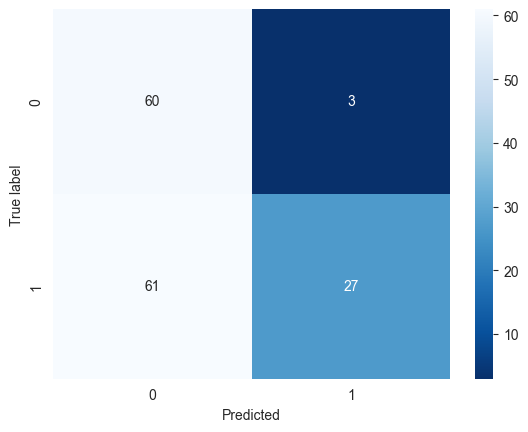

In [105]:
# Построение матрицы ошибок
cm_new = confusion_matrix(y_test, y_pred_threshold)
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted');

In [106]:
print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print()
print('New Accuracy: {:.3f}'.format(accuracy_new))
print('New Precision: {:.3f}'.format(precision_new))
print('New Recall: {:.3f}'.format(recall_new))

Accuracy: 0.596
Precision: 0.629
Recall: 0.750

New Accuracy: 0.576
New Precision: 0.900
New Recall: 0.307


Вывод: 
- Accuracy уменьшилась до 57,6%
- Precision увеличилась до 90%
- Recall уменьшилась до 30.7%

С увеличением метрики Precision фермер купит корову, которая дает вкусное молоко.

### Предсказание вкуса молока

In [107]:
#создаем копию датасета
cow_buy_log = cow_buy.copy(deep=True)

#считаем среднее значение каждого недостающего признака и увеличиваем их на 5%
mean_values = ferma_main[['эке', 'сырой_протеин, г', 'спо']].mean()
new_values = mean_values * 1.05


#добавляем недостающие признаки в датасет cow_buy и преобразовываем их
cow_buy_log['эке'] = new_values['эке']
cow_buy_log['эке_2'] = cow_buy_log['эке'] ** 2
cow_buy_log['сырой_протеин, г'] = new_values['сырой_протеин, г']
cow_buy_log['спо'] = new_values['спо']
cow_buy_log['спо_кат'] = cow_buy_log['спо'].apply(lambda x: 'менее_0.92' if x < 0.92 else 'более_0.92')

#поменяем названия столбцов
cow_buy_log.rename(columns={'текущая_жирность': 'жирность', 'текущий_белок': 'белок'}, inplace=True)
#удаляем ненужные столбцы cow_buy
cow_buy_log = cow_buy_log.drop(['эке', 'спо'], axis=1)
cow_buy_log.head()

,порода,тип_пастбища,порода_папы,имя_папы,жирность,белок,возраст,"удой, кг",эке_2,"сырой_протеин, г",спо_кат
0,Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6591.874384,233.063152,2019.55183,более_0.92
1,Айдиал,равнинное,Соверинг,Буйный,3.54,3.081,менее_2_лет,6308.506499,233.063152,2019.55183,более_0.92
2,Соверинг,равнинное,Соверинг,Барин,3.59,3.074,более_2_лет,6282.933373,233.063152,2019.55183,более_0.92
3,Соверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,6572.816579,233.063152,2019.55183,более_0.92
4,Соверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,6521.264214,233.063152,2019.55183,более_0.92


In [110]:
#разделим признаки на категориальные и количественные
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы', 'возраст', 'спо_кат', 'имя_папы']
num_col_names = ['эке_2', 'сырой_протеин, г', 'жирность', 'белок', 'удой, кг']

#кодируем категориальные признаки
#encoder = OneHotEncoder(drop='first', sparse=False)
cow_buy_ohe = encoder.transform(cow_buy_log[cat_col_names])
encoder_col_names = encoder.get_feature_names_out()

cow_buy_ohe = pd.DataFrame(cow_buy_ohe, columns=encoder_col_names)


#масштабируем количественные признаки
#scaler = StandardScaler()
cow_buy_scaled = scaler.transform(cow_buy_log[num_col_names])
cow_buy_scaled = pd.DataFrame(cow_buy_scaled, columns=num_col_names)


cow_buy_new_log = pd.concat([cow_buy_ohe, cow_buy_scaled], axis=1)

In [111]:
cow_buy['вкус_молока'] = (clf.predict_proba(cow_buy_new_log)[:, 1] >= 0.71).astype(int)
cow_buy['вкус_молока'] = cow_buy['вкус_молока'].apply(lambda x: 'вкусно' if x == 1 else 'не вкусно')
cow_buy

,порода,тип_пастбища,порода_папы,имя_папы,текущая_жирность,текущий_белок,возраст,"удой, кг",вкус_молока
0,Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6591.874384,вкусно
1,Айдиал,равнинное,Соверинг,Буйный,3.54,3.081,менее_2_лет,6308.506499,не вкусно
2,Соверинг,равнинное,Соверинг,Барин,3.59,3.074,более_2_лет,6282.933373,не вкусно
3,Соверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,6572.816579,не вкусно
4,Соверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,6521.264214,не вкусно
5,Соверинг,равнинное,Соверинг,Геркулес,3.63,3.053,менее_2_лет,6376.723578,не вкусно
6,Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6591.874384,вкусно
7,Айдиал,равнинное,Соверинг,Буйный,3.57,3.079,более_2_лет,6524.443267,не вкусно
8,Соверинг,равнинное,Соверинг,Барин,3.59,3.074,более_2_лет,6282.933373,не вкусно
9,Соверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,6356.879811,вкусно


In [112]:
to_buy = cow_buy.loc[(cow_buy['вкус_молока'] == 'вкусно') & (cow_buy['удой, кг'] >= 6000)]

to_buy

,порода,тип_пастбища,порода_папы,имя_папы,текущая_жирность,текущий_белок,возраст,"удой, кг",вкус_молока
0,Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6591.874384,вкусно
6,Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6591.874384,вкусно
9,Соверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,6356.879811,вкусно
13,Айдиал,холмистое,Соверинг,Барин,3.42,3.075,менее_2_лет,6093.969333,вкусно


In [113]:
to_buy.duplicated().sum()

1

Вывод: имеется один дубликат, избавимся от него.

In [114]:
to_buy = to_buy.drop_duplicates(keep='first')
to_buy

,порода,тип_пастбища,порода_папы,имя_папы,текущая_жирность,текущий_белок,возраст,"удой, кг",вкус_молока
0,Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6591.874384,вкусно
9,Соверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,6356.879811,вкусно
13,Айдиал,холмистое,Соверинг,Барин,3.42,3.075,менее_2_лет,6093.969333,вкусно


Вывод: имеется три коровы готовые к продаже.

## Итоговые выводы

**1. Загрузка и изучение данных.**
- `ferma_main`: в данных имеется 634 записи, пропуски отсутствуют, выявили 5 явных дубликатов, необходимо изменить типы данных некоторых столбцов, необходимо привести названия столбцов к одному виду;
- `ferma_dad`: в данных имеется 629 записи, пропуски и явные дубликаты отсутствуют, необходимо привести названия столбцов к одному виду;
- `cow_buy`: в данных имеется 29 записей, пропуски отсутствуют, выявили 4 явных дубликата, необходимо изменить типы данных некоторых столбцов, необходимо привести названия столбцов к одному виду;


**2. Предобработка данных.**

- Удалили увные дуликаты;
- Обработали неявные дубликаты в столбцах `тип_пастбища, порода, порода_папы`;
- Привели названия к единому виду
- `ferma_main`: изменили тип данных в столбцах эке, спо, жирность, %, белок, % на float;
- `cow_buy`: изменили тип данных в столбцах текущая_жирность, %, текущий_белок, % на float.


**3. Исследовательский анализ.**

- Практически все признаки имеют нормальное распределение;
- Удалили аномальное значения признака `удой, кг`;
- Удалили выбросы в признаке `белок`;
- В категориальных данных изменения не вносились.


**4. Корреляционный анализ.**

- Целевым признаком приняли `удой, кг`;
- `ЭКЕ`: коэффициент корреляции равен 0.72 это указывает на достаточно сильную положительную взаимосвязь, по диаграмме рассеяния видно, что для обоих пород это утверждение справедливо, с увеличением удоя увеличивается ЭКЕ.
- `Сырой протеин`: коэффициент корреляции равен 0.46, по диаграмме рассеяния виден большой разброс значений, при этом наблюдается положительная зависимость.
- `СПО`: коэффициент корреляции равен 0.66, по диаграмме рассеяния виден большой разброс значений, при этом наблюдается положительная зависимость.
- `Жирность`: коэффициент корреляции равен 0.71, наблюдается положительная зависимость, до значения жирности 3,5 наблюдается разброс значений.
- `Белок`: коэффициент корреляции равен 0.23 указывает на нелинейную взаимосвязь признаков, по диаграмме рассеяния видно, что есть зависимость белка и породой. Больше белка у породы Вис Бик Айдиал, меньше у Рефлешн Соверинг.
- `возраст` имеет коэффициент корреляции 1.0
- Нелинейные связи имеются, но добавление новых признаков не потребовалось.
- Матрица корреляции показала, что между некоторыми входными признаками есть умеренная корреляция, но нет явных признаков сильной мультиколлинеарности.


**5. Задача регрессии.**

- Обучили три модели линейной регрессии проанализировали метрики и остатки;
- Выявили лучшую модель линейной регрессии с метриками:
    - R2 = 0.843
    - MSE = 37869.407023
    - MAE = 149.600595
    - RMSE = 194.600635
- Спрогнозировали годовой удой коров, который варьируется от 5817 до 6511 кг.


**6. Задача классификации.**

- Обучили модель логистической регрессии;
- Проанализировали метрики модели и уменьшили количество критических ошибок первого рода с 39 до 3, подобрав новый порог для вероятности предсказаний.
- Подобрали 3 коровы к продаже, у которых вкусное молоко и удой больше 6 тонн/год. Для фермера наиболее значима будет покупка коровы, которая дает вкусное молоко.